In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import calinski_harabasz_score, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

# Первичная обработка данных

Импортируем данные и посмотрим на них.

In [3]:
fpath = "/kaggle/input/wine-reviews/winemag-data-130k-v2.csv"
df = pd.read_csv(fpath, index_col=0)
df.shape

(129971, 13)

In [4]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Удалим колонки, которые напрямую не относятся к свойствам вина (`taster_name`, `taster_twitter_handle`), а также те колонки, которые являются дубликатами других полей (`region`), из-за чего их может быть труднее кластеризовать.

In [5]:
df.drop(columns=["region_1", "region_2", "taster_name",
                 "taster_twitter_handle"],
        inplace=True)
df.head()

,country,description,designation,points,price,province,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
df.dtypes

country         object
description     object
designation     object
points           int64
price          float64
province        object
title           object
variety         object
winery          object
dtype: object

Избавляемся от текстовых колонок.

In [7]:
len(df["country"].unique())

44

In [8]:
len(df["province"].unique())

426

In [9]:
len(df["variety"].unique())

708

Поскольку `country`, `province` и `variety` представляют собой категориальные переменные, их имеет смысл преобразовать с помощью LabelEncoder.

In [10]:
labels = ["country", "province", "variety"]

In [11]:
res = df.copy()

for col in labels:
    res[col] = LabelEncoder().fit_transform(res[col])

In [12]:
res.head()

,country,description,designation,points,price,province,title,variety,winery
0,22,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,331,Nicosia 2013 Vulkà Bianco (Etna),690,Nicosia
1,31,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,108,Quinta dos Avidagos 2011 Avidagos Red (Douro),450,Quinta dos Avidagos
2,40,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,268,Rainstorm 2013 Pinot Gris (Willamette Valley),436,Rainstorm
3,40,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,218,St. Julian 2013 Reserve Late Harvest Riesling ...,479,St. Julian
4,40,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,268,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,440,Sweet Cheeks


Оставшиеся текстовые колонки преобразуем при помощи Doc2Vec.

In [13]:
text_cols = ["designation", "winery"]

for col in text_cols:
    print(col)
    res[col] = res[col].astype(str)

    res[col] = res[col].apply(lambda x: x.lower().split())

    txt_to_vec = list(res[col].values)

    docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(txt_to_vec)]

    model = Doc2Vec(docs, vector_size=1, window=2, min_count=1, workers=4)

    vectors = []
    for x in docs:
        temp = list(model.dv[x.tags][0])
        vectors.append(temp)
    
    split_df = pd.DataFrame(vectors,
                            columns=[col + "_1"])
    
    res = res.join(split_df, how='left')

res.drop(columns=text_cols,
         inplace=True)

designation
winery


In [14]:
text_cols = ["title", "description"]

for col in text_cols:
    print(col)
    res[col] = res[col].astype(str)

    res[col] = res[col].apply(lambda x: x.lower().split())

    txt_to_vec = list(res[col].values)

    docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(txt_to_vec)]

    model = Doc2Vec(docs, vector_size=5, window=2, min_count=1, workers=4)

    vectors = []
    for x in docs:
        temp = list(model.dv[x.tags][0])
        vectors.append(temp)
    
    split_df = pd.DataFrame(vectors,
                            columns=[col + "_1", col + "_2", col + "_3", col + "_4", col + "_5"])
    
    res = res.join(split_df, how='left')

res.drop(columns=text_cols,
         inplace=True)

title
description


In [15]:
res.shape

(129971, 17)

In [16]:
res.head()

,country,points,price,province,variety,designation_1,winery_1,title_1,title_2,title_3,title_4,title_5,description_1,description_2,description_3,description_4,description_5
0,22,87,NaN,331,690,-0.410599,-0.417134,-0.172943,0.013987,-0.082313,-0.013453,-0.010453,0.180743,-0.046338,-0.102812,0.064747,0.009889
1,31,87,15.0,108,450,-0.479892,-0.507278,0.095801,-0.105087,0.136084,-0.147447,-0.086609,0.043078,0.255781,0.487835,-0.307161,-0.008373
2,40,87,14.0,268,436,-0.988075,-0.877592,0.004757,0.054395,-0.084275,-0.108135,-0.029576,0.304718,0.227314,-0.051219,-0.169954,0.046682
3,40,87,13.0,218,479,0.884341,0.884893,-0.324192,-0.014917,0.174822,0.005220,0.054207,-0.154251,0.058981,0.359606,-0.236417,0.121583
4,40,87,65.0,268,440,0.504056,0.434332,-0.091548,0.203756,-0.045462,0.049092,0.250287,-0.031312,0.027401,0.327495,-0.032234,-0.110405


In [17]:
res.dtypes

country            int64
points             int64
price            float64
province           int64
variety            int64
designation_1    float32
winery_1         float32
title_1          float32
title_2          float32
title_3          float32
title_4          float32
title_5          float32
description_1    float32
description_2    float32
description_3    float32
description_4    float32
description_5    float32
dtype: object

In [18]:
res.isna().any()

country          False
points           False
price             True
province         False
variety          False
designation_1    False
winery_1         False
title_1          False
title_2          False
title_3          False
title_4          False
title_5          False
description_1    False
description_2    False
description_3    False
description_4    False
description_5    False
dtype: bool

In [19]:
res[res["price"].isna()]

,country,points,price,province,variety,designation_1,winery_1,title_1,title_2,title_3,title_4,title_5,description_1,description_2,description_3,description_4,description_5
0,22,87,NaN,331,690,-0.410599,-0.417134,-0.172943,0.013987,-0.082313,-0.013453,-0.010453,0.180743,-0.046338,-0.102812,0.064747,0.009889
13,22,87,NaN,331,387,-0.225124,-0.166067,-0.130128,0.254485,0.155761,-0.217171,-0.177012,-0.060889,0.456812,0.135174,-0.202882,-0.027500
30,15,86,NaN,29,194,0.601896,0.624385,0.117793,0.296559,0.070937,-0.209859,-0.092455,-0.124494,0.324927,0.221539,-0.128441,-0.108065
31,22,86,NaN,331,473,0.844162,0.737322,-0.113242,0.078008,0.235922,-0.185426,-0.276542,0.259499,-0.014814,0.257101,-0.084434,-0.240392
32,22,86,NaN,331,690,-0.479353,-0.530619,0.063458,0.295221,0.320085,-0.159126,-0.074354,0.622265,0.255366,0.002837,0.104230,-0.127050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129844,22,86,NaN,374,506,0.072729,0.034001,0.122950,0.129567,0.098672,-0.413625,-0.132364,0.270009,0.142092,0.201587,-0.197117,-0.396112
129860,31,90,NaN,108,450,-0.661116,-0.860206,-0.051716,0.176915,0.157050,-0.069307,-0.080859,-0.103055,0.309134,0.197102,-0.221820,0.075060
129863,31,90,NaN,112,450,-0.349104,-0.274854,0.077398,0.142462,0.195407,0.241427,-0.153090,-0.036317,0.297797,0.256968,0.271031,0.082994
129893,22,91,NaN,384,197,0.137560,0.070662,-0.022317,0.184008,0.116725,-0.134696,0.072329,-0.071962,0.458394,-0.098505,-0.182176,0.293301


In [20]:
res.shape

(129971, 17)

In [21]:
res.dropna(inplace=True)
res.shape

(120975, 17)

In [22]:
res.isna().any()

country          False
points           False
price            False
province         False
variety          False
designation_1    False
winery_1         False
title_1          False
title_2          False
title_3          False
title_4          False
title_5          False
description_1    False
description_2    False
description_3    False
description_4    False
description_5    False
dtype: bool

Взглянем на распределения данных.

In [23]:
res.skew()

country          -0.639315
points            0.040256
price            18.000957
province          0.342786
variety          -0.250625
designation_1    -0.005140
winery_1          0.003371
title_1           0.004371
title_2          -0.039433
title_3          -0.035051
title_4           0.087692
title_5          -0.034586
description_1     0.028148
description_2    -0.114443
description_3     0.002985
description_4    -0.195083
description_5    -0.153210
dtype: float64

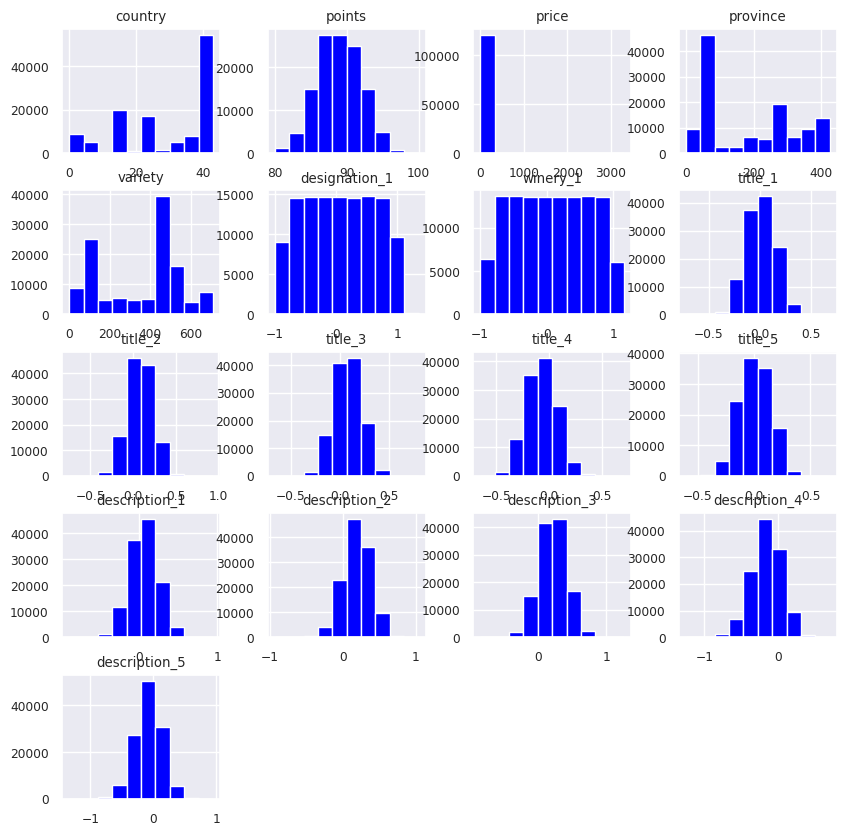

In [24]:
sns.set(font_scale=0.8, rc={'figure.figsize': (10, 10)})

ax = res.hist(color='blue')

Скалируем данные.

In [25]:
std_scaler = StandardScaler()
data_scaled = res.copy()
data_scaled[data_scaled.columns]=std_scaler.fit_transform(data_scaled)

data_scaled.head()

,country,points,price,province,variety,designation_1,winery_1,title_1,title_2,title_3,title_4,title_5,description_1,description_2,description_3,description_4,description_5
1,0.204250,-0.467033,-0.496401,-0.531178,0.478899,-0.959751,-1.053493,0.592018,-1.278335,0.388859,-0.534026,-0.694359,-0.118509,0.352622,1.334266,-0.723693,0.324835
2,0.891544,-0.467033,-0.520778,0.629620,0.407187,-1.858336,-1.718434,-0.062675,-0.201436,-1.183366,-0.259371,-0.278580,1.334092,0.200620,-1.299642,-0.057691,0.586333
3,0.891544,-0.467033,-0.545155,0.266871,0.627447,1.452525,1.446305,-2.428127,-0.669464,0.665243,0.532589,0.332206,-1.214058,-0.698212,0.707717,-0.380300,0.942088
4,0.891544,-0.467033,0.722456,0.629620,0.427676,0.780094,0.637273,-0.755200,0.807119,-0.906445,0.839104,1.761652,-0.531516,-0.866835,0.550817,0.610805,-0.159788
5,0.662446,-0.467033,-0.496401,0.586090,1.196024,0.290985,0.025635,-0.757782,0.523301,0.652975,-0.319596,-1.178218,0.187728,-0.243395,0.212896,0.300345,-0.803196


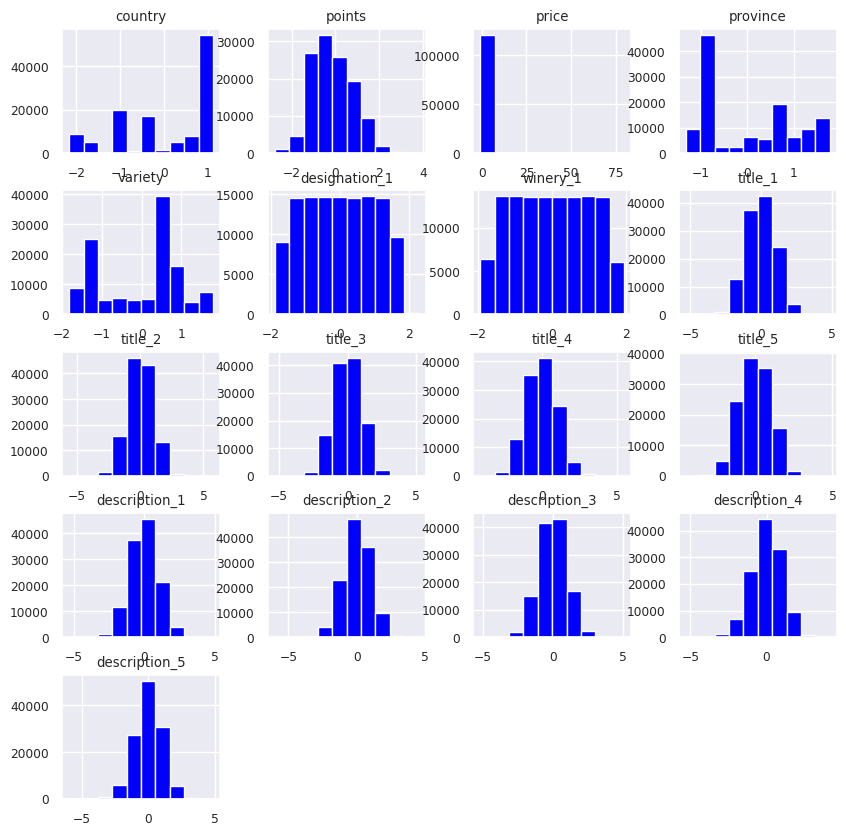

In [26]:
sns.set(font_scale=0.8, rc={'figure.figsize': (10, 10)})

ax = data_scaled.hist(color='blue')

In [27]:
data_scaled.describe()

,country,points,price,province,variety,designation_1,winery_1,title_1,title_2,title_3,title_4,title_5,description_1,description_2,description_3,description_4,description_5
count,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05,1.209750e+05
mean,-2.419869e-17,1.402114e-15,-1.133579e-17,6.648765e-17,1.047827e-16,-2.784024e-17,1.856016e-17,2.619567e-17,-1.456620e-17,3.242154e-17,-7.987916e-18,-1.409632e-17,3.571068e-17,1.597583e-17,6.954186e-17,-7.330087e-17,-3.054203e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.163095e+00,-2.766265e+00,-7.645496e-01,-1.314718e+00,-1.826144e+00,-1.880920e+00,-1.931065e+00,-5.303638e+00,-5.618871e+00,-5.319528e+00,-4.063230e+00,-4.453170e+00,-5.315245e+00,-6.003321e+00,-5.187635e+00,-5.297774e+00,-5.985429e+00
25%,-1.017606e+00,-7.954949e-01,-4.476468e-01,-9.447130e-01,-1.185854e+00,-8.604570e-01,-8.651704e-01,-7.294263e-01,-6.945004e-01,-7.178448e-01,-7.137475e-01,-7.297266e-01,-6.757740e-01,-6.644245e-01,-6.721440e-01,-6.468338e-01,-6.486358e-01
50%,6.624456e-01,-1.385716e-01,-2.526297e-01,-8.136901e-02,4.276762e-01,1.831025e-04,-1.452103e-04,-2.229952e-03,-1.834995e-03,1.875326e-03,-1.545194e-03,-2.304121e-03,-2.849012e-03,1.616932e-02,2.348774e-04,3.132643e-02,1.890725e-02
75%,8.915436e-01,8.468134e-01,1.617816e-01,7.602100e-01,6.940367e-01,8.624641e-01,8.649274e-01,7.238456e-01,7.008978e-01,7.232622e-01,6.997916e-01,7.397252e-01,6.689574e-01,6.786081e-01,6.755747e-01,6.802616e-01,6.759487e-01
max,1.120641e+00,3.802968e+00,7.958249e+01,1.768654e+00,1.795335e+00,2.277503e+00,1.945073e+00,4.850608e+00,5.748489e+00,5.166590e+00,5.471682e+00,4.826764e+00,4.875513e+00,4.521274e+00,5.117508e+00,4.159633e+00,4.872252e+00


<AxesSubplot:>

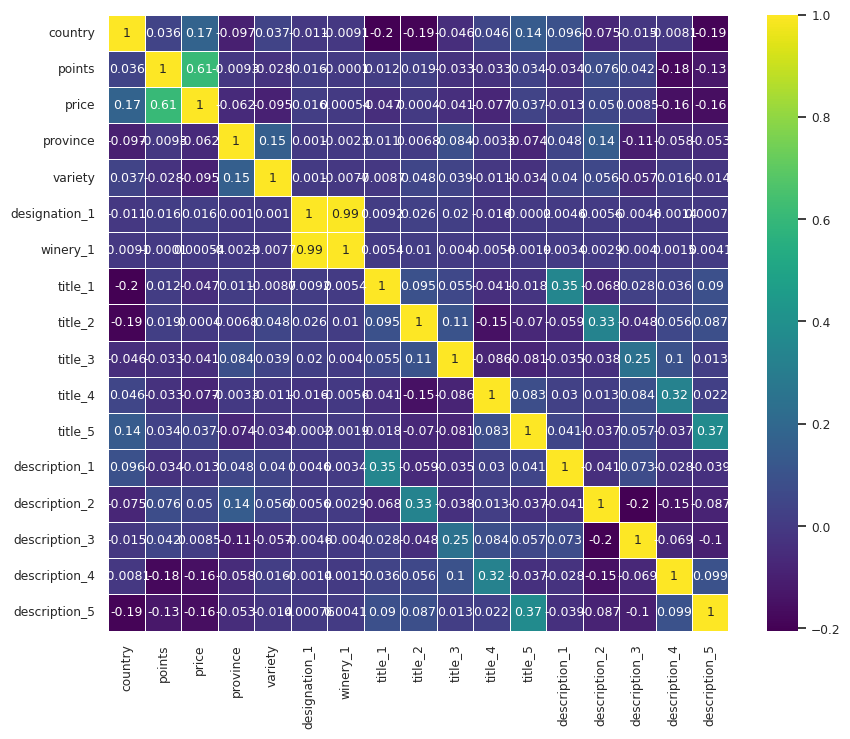

In [28]:
corr = data_scaled.corr(method="spearman")

plt.figure(figsize=(10,8))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True,annot_kws={"size": 9})

# KMeans

Прежде чем приступать к непосредственно кластеризации, нужно уменьшить размерность датасета с 17 параметров, например, до двух. Для решения этой задачи используем метод главных компонент.

In [29]:
pca_2 = PCA(2)

pca_2_res = pca_2.fit_transform(data_scaled) 

pca_2_res.shape

(120975, 2)

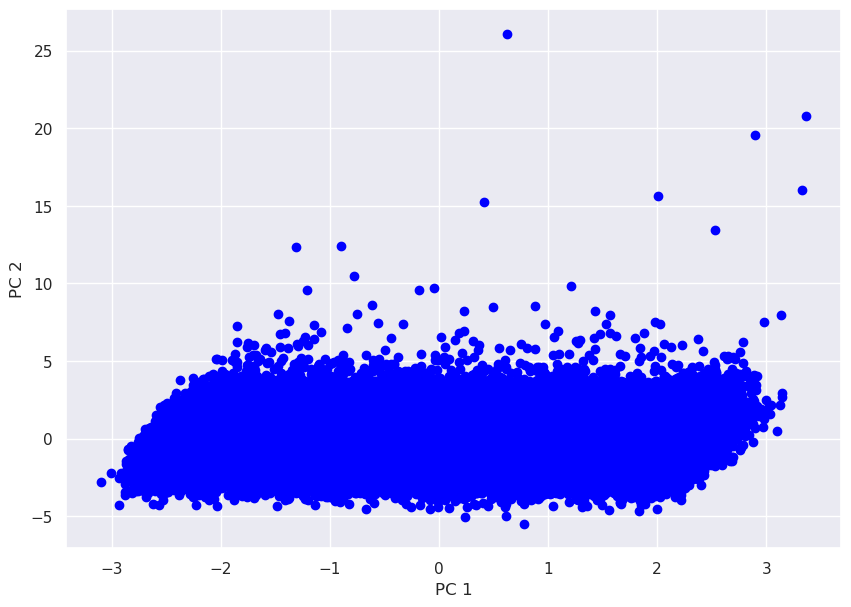

In [30]:
sns.set(rc={'figure.figsize': (10, 7)})

plt.scatter(x=pca_2_res[:, 0], y=pca_2_res[:, 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()

Для начала определим оптимальное количество кластеров.

In [31]:
params = np.arange(2, 16)

j = []
m = []
for k in params:
    kmns = KMeans(n_clusters = k, random_state = 8, n_init = 4, max_iter = 1000)
    kmns.fit(pca_2_res)
    j.append(kmns.inertia_)
    m.append(calinski_harabasz_score(pca_2_res, kmns.labels_))
j = np.array(j)
m = np.array(m)

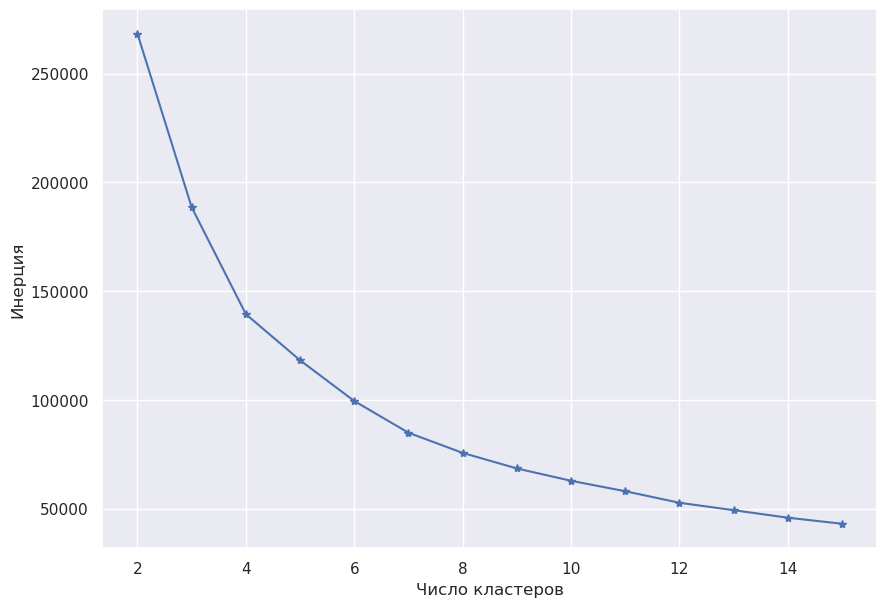

In [32]:
plt.plot(params, j, '-*')
plt.xlabel("Число кластеров")
plt.ylabel("Инерция")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

По методу локтя не очевидно, какое число кластеров оптимально в данном случае.

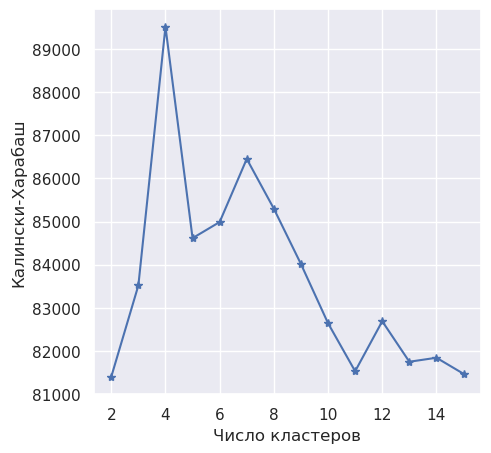

In [33]:
plt.plot(params, m, "-*")
plt.xlabel('Число кластеров')
plt.ylabel('Калински-Харабаш')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Кажется, что количество кластеров лучше взять 4. Можно также сравнить значения силуэта для разных k, но silhouette score очень долго вычисляется.

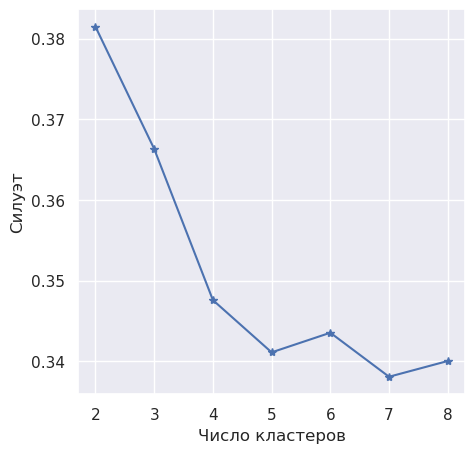

In [34]:
j = []
params = np.arange(2, 9)
for k in params:
    kmns2 = KMeans(n_clusters = k, random_state = 8, n_init = 4, max_iter = 1000)
    kmns2.fit(pca_2_res)
    j.append(silhouette_score(pca_2_res, kmns2.labels_))
j = np.array(j)
plt.plot(params, j, "-*")
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт')
plt.show()

Возьмем k=4.

In [35]:
kmns = KMeans(n_clusters = 4, random_state = 8, n_init = 4, max_iter = 1000)

y_pred = kmns.fit_predict(pca_2_res)

centroids = kmns.cluster_centers_

Посмотрим на все метрики и график силуэта для k=4 в деталях.

In [36]:
def metrics(X, y_pred):
    print("Калински-Харабаш: %.4f" % calinski_harabasz_score(X, y_pred))

    silhouette_avg = silhouette_score(X, y_pred)
    print("Средний силуэт: %.4f" % silhouette_avg)

    n_clusters = len(np.unique(y_pred))

    fig, ax1 = plt.subplots(figsize=(8,6))
    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    sample_silhouette_values = silhouette_samples(X, y_pred)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.get_cmap("nipy_spectral")(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Силуэты кластеров")
    ax1.set_xlabel("Значение силуэта")
    ax1.set_ylabel("Кластер")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="-.")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Калински-Харабаш: 89519.9063
Средний силуэт: 0.3476
Сумма квадратов расстояний до центроидов: 139401.8060


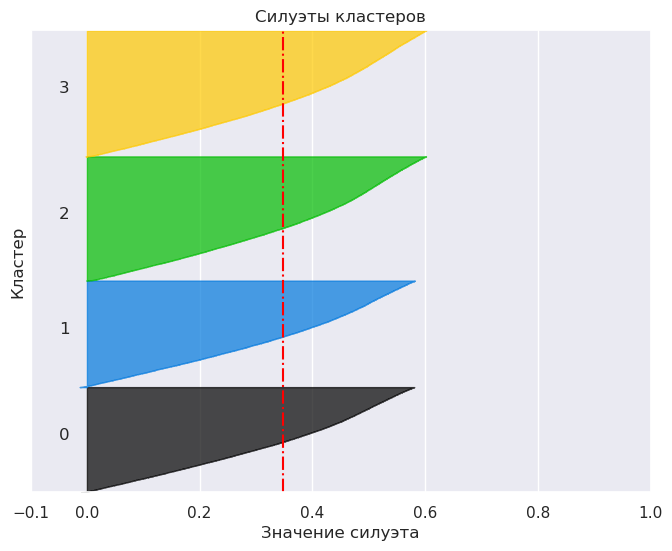

In [37]:
metrics(pca_2_res, y_pred)
print("Сумма квадратов расстояний до центроидов: %.4f" % kmns.inertia_)

Видно, что кластеры при k=4 распределены равномерно, нет отрицательных значений на графике силуэта. Таким образом, при помощи KMeans вина из набора данных делятся на 4 разных кластера.

Посмотрим на то, как кластеры выглядят на графике.

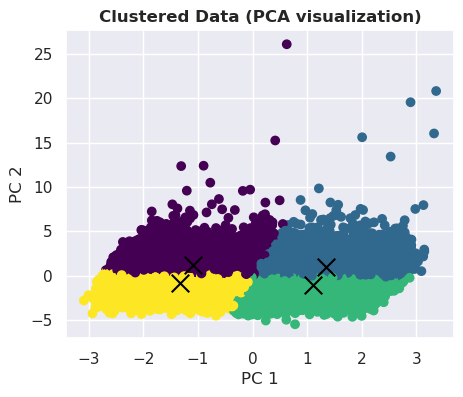

In [38]:
sns.set(rc={'figure.figsize': (5, 4)}, font_scale=1)

plt.scatter(x=pca_2_res[:, 0], y=pca_2_res[:, 1], c=y_pred, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Clustered Data (PCA visualization)', fontweight='bold')

plt.show()

Кластеры получились очень плотные, с некоторыми выбросами. Однако границы кластеров визуально тяжело различить.

# DBSCAN

Возьмем min_samples=6.

In [54]:
cluster = DBSCAN(min_samples=6, eps=0.1)

y_pred = cluster.fit_predict(pca_2_res)

Посмотрим на все метрики и график силуэта для min_samples=6 в деталях.

Калински-Харабаш: 85.0789
Средний силуэт: 0.0739


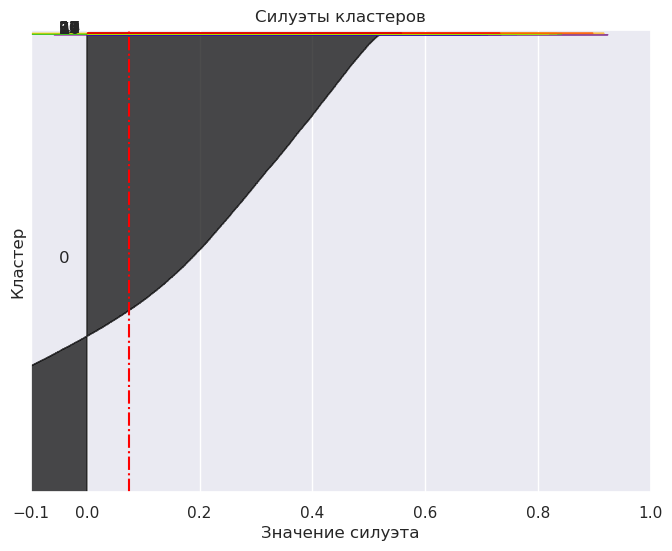

In [55]:
metrics(pca_2_res, y_pred)

Глядя на силуэт, можно сказать, что кластеры разделились плохо: есть один большой кластер с большим "заездом" в отрицательные значения.

Посмотрим, как кластеры выглядят на графике.

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

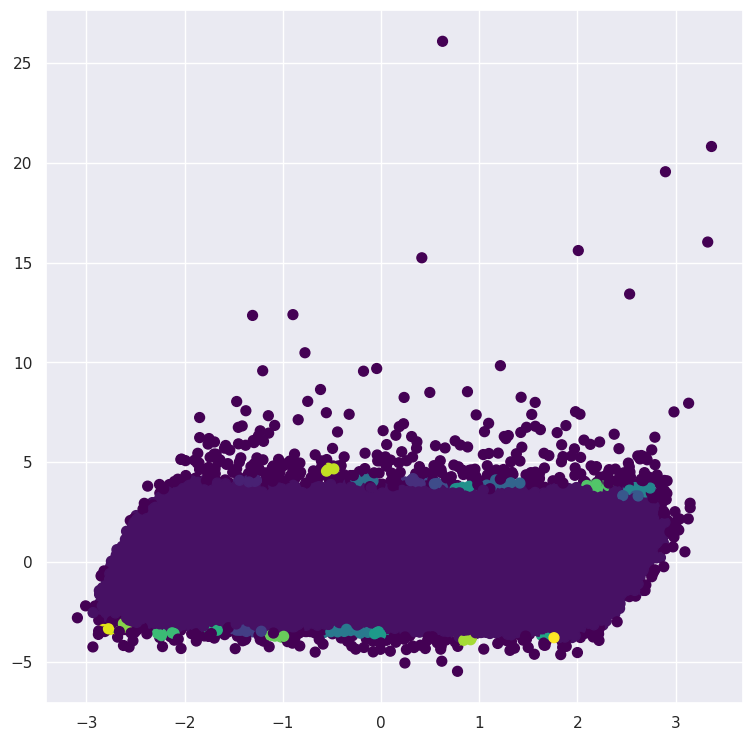

In [57]:
centroids = cluster.labels_

plt.scatter(x=pca_2_res[:, 0], y=pca_2_res[:, 1], c=y_pred, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

Поскольку данные после уменьшения размерности получились очень плотные, DBSCAN не очень подходит для кластеризации. Большое "облако" точек, которые находятся слишком близко друг к другу и большое количество выбросов в верхней части графика мешают эффективной кластеризации.